# CEES – Crime Escalation Early-warning System

This notebook implements the CEES prototype, a machine learning and NLP system designed to classify short crime-style incident narratives into three escalation levels:

- **low**
- **medium**
- **high**

The goal is to demonstrate a *proof-of-concept* for using NLP and machine learning in criminological risk assessment, not to build a production-ready model.


In [1]:
# 1. Imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline


## 2. Dataset

We load the synthetic pilot dataset of 29 narratives, labelled as **low**, **medium** or **high** escalation risk.


In [5]:
df = pd.read_csv("/content/dataset.csv")

df.head()

,text,escalation_level
0,"Neighbour reports loud music and shouting, no ...",low
1,"Caller reports argument between couple, no inj...",medium
2,Woman states ex-partner followed her home twic...,high
3,Shop owner reports single incident of minor va...,low
4,Victim reports receiving repeated unwanted mes...,medium


In [6]:
# 3. Podział danych na trening i test

X = df['text']
y = df['escalation_level']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,      # 30% danych na test
    random_state=42,
    stratify=y          # utrzymuje proporcje klas
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print(y_train.value_counts())
print(y_test.value_counts())


Train size: 20
Test size: 9
escalation_level
high      8
medium    7
low       5
Name: count, dtype: int64
escalation_level
high      3
medium    3
low       3
Name: count, dtype: int64


In [7]:
# 4. CEES 2.0 – TF-IDF + Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 4.1 TF-IDF
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english'
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 4.2 Model logistyczny
clf = LogisticRegression(
    max_iter=1000,
    multi_class="auto"
)

clf.fit(X_train_vec, y_train)

# 4.3 Ewaluacja
y_pred = clf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7777777777777778

Classification report:

              precision    recall  f1-score   support

        high       0.60      1.00      0.75         3
         low       1.00      1.00      1.00         3
      medium       1.00      0.33      0.50         3

    accuracy                           0.78         9
   macro avg       0.87      0.78      0.75         9
weighted avg       0.87      0.78      0.75         9



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


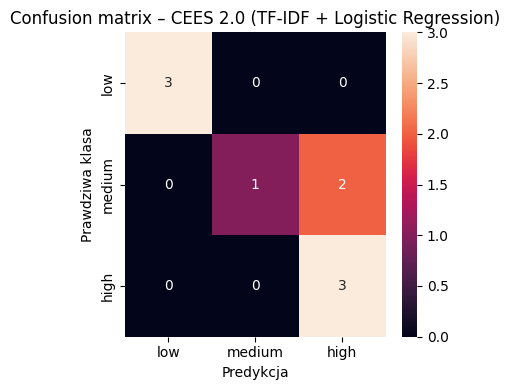

In [8]:
# 4.4 Confusion matrix – wizualizacja

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['low', 'medium', 'high']
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.title("Confusion matrix – CEES 2.0 (TF-IDF + Logistic Regression)")
plt.tight_layout()
plt.show()


In [9]:
# 4.5 Najważniejsze słowa dla każdej klasy

feature_names = vectorizer.get_feature_names_out()
classes = clf.classes_

for i, cls in enumerate(classes):
    coefs = clf.coef_[i]
    top_indices = np.argsort(coefs)[-10:]  # 10 najsilniejszych słów
    print(f"\nTop words for class '{cls}':")
    for idx in top_indices:
        print(feature_names[idx])



Top words for class 'high':
streets
unknown
victim
followed
escalating
harassment
male
ex
partner
property

Top words for class 'low':
shop
wall
resident
overnight
graffiti
complains
dispute
parking
neighbour
prior

Top words for class 'medium':
attempt
pickpocketing
threatened
car
couple
arguing
physical
loudly
injuries
argument


In [10]:
!pip install transformers


In [11]:
from transformers import pipeline

zero_shot = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

candidate_labels = ["low", "medium", "high"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [12]:
def predict_zero_shot(texts, labels):
    preds = []
    for t in texts:
        out = zero_shot(t, candidate_labels=labels)
        preds.append(out['labels'][0])  # najlepsza odpowiedź
    return preds


In [13]:
y_pred_zeroshot = predict_zero_shot(X_test.tolist(), candidate_labels)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy (zero-shot):", accuracy_score(y_test, y_pred_zeroshot))
print("\nClassification report (zero-shot):\n")
print(classification_report(y_test, y_pred_zeroshot))


Accuracy (zero-shot): 0.3333333333333333

Classification report (zero-shot):

              precision    recall  f1-score   support

        high       0.50      0.33      0.40         3
         low       0.00      0.00      0.00         3
      medium       0.29      0.67      0.40         3

    accuracy                           0.33         9
   macro avg       0.26      0.33      0.27         9
weighted avg       0.26      0.33      0.27         9



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


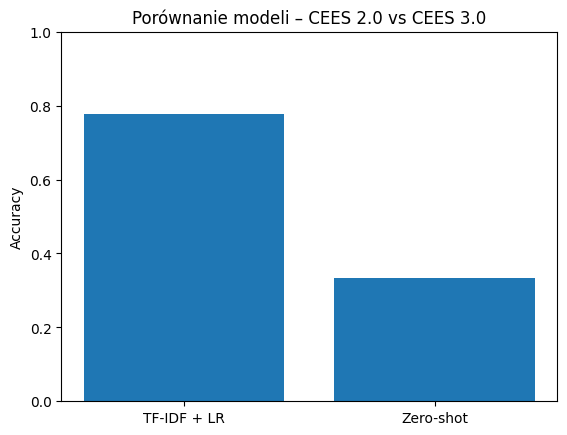

In [14]:
# 6. Porównanie dokładności modeli

acc_tfidf = accuracy_score(y_test, y_pred)
acc_zeroshot = accuracy_score(y_test, y_pred_zeroshot)

plt.bar(["TF-IDF + LR", "Zero-shot"], [acc_tfidf, acc_zeroshot])
plt.ylabel("Accuracy")
plt.title("Porównanie modeli – CEES 2.0 vs CEES 3.0")
plt.ylim(0, 1)
plt.show()
